# Contextual Bandits Agent with Policy Gradient Method (Deterministic) in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from main import deterministic_training
from Environment import *
plt.rcParams.update({'font.size': 15})
import pyarrow.feather as feather

In [67]:
training_platform = TrainingPlatform.Notebook
agent_num = 1
action_num = 2
feature_num = 3
signal_size = 1
decay_rate = 0  # 0.001
learning_rate_theta = 1e-5 / signal_size
learning_rate_wv = 1e-3 / signal_size
learning_rate_wq = 2e-3 / signal_size
memory_size = 16
batch_size = 16
training_episodes = int(4e6)
beta1 = 0.9
beta2 = 0.9999
fixed_std = 0.3
algorithm = Algorithm.REGULAR
# Bucket parameters
# prior_red_list = [3 / 4, 1 / 4] 
prior_red_list = None
pr_red_ball_red_bucket = 2 / 3
pr_red_ball_blue_bucket = 1 / 3


explorer_learning = False
decision_rule = DecisionRule.STOCHASTIC
score_func = ScoreFunction.LOG
preferred_colour_pr_list = [0.9, 0.1]
agent_list = []
evaluation_step = 10
weights_init = WeightsInit.ZERO
report_order = ReportOrder.FIXED
signal_size_list = np.ones(shape=agent_num, dtype=int) * signal_size


metric_dict = deterministic_training(training_platform, agent_list, feature_num, action_num, learning_rate_theta, learning_rate_wv, learning_rate_wq,
                                             memory_size, batch_size, training_episodes,
                                             decay_rate, beta1, beta2, algorithm, pr_red_ball_red_bucket,
                                             pr_red_ball_blue_bucket, prior_red_list, agent_num,
                                             explorer_learning, fixed_std, score_func, decision_rule, preferred_colour_pr_list, evaluation_step, weights_init, report_order, signal_size_list)

agent0
learning_rate_theta= 1e-05
learning_rate_wv= 0.001  learning_rate_wq= 0.002
memory_size= 16
Updating weights with Regular algorithm.


  0%|          | 0/4000000 [00:00<?, ?it/s]

In [68]:
import os

sequence_number = 1
parent_folder_name = 'Temp' # 'Deterministic' or 'Stochastic'

dir_name = r'ag{}_ac{}_sig{}_lrt{}_te{}_{}_{}_{}_{}_{}_{}_{}_{}/'.format(agent_num, action_num, signal_size, learning_rate_theta, 
                                    training_episodes, algorithm.name, 
                                    'normal' if prior_red_list is None else 'list',
                                    preferred_colour_pr_list, score_func.name,
                                    decision_rule.name, weights_init.name, report_order.name, sequence_number)

dir_path = r'./data/{}/{}'.format(parent_folder_name, dir_name)

while os.path.exists(dir_path):
    sequence_number += 1
    dir_name = r'ag{}_ac{}_sig{}_lrt{}_te{}_{}_{}_{}_{}_{}_{}_{}_{}/'.format(agent_num, action_num, signal_size, learning_rate_theta, 
                                    training_episodes, algorithm.name, 
                                    'normal' if prior_red_list is None else 'list',
                                    preferred_colour_pr_list, score_func.name,
                                    decision_rule.name, weights_init.name, report_order.name, sequence_number)
    dir_path = r'./data/{}/{}'.format(parent_folder_name, dir_name)
    


os.makedirs(dir_path)

In [69]:
backwards_index = -int(1e6)
print(np.mean(metric_dict['prior_outcome'][backwards_index:]))
print(np.mean(metric_dict['dm_outcome'][backwards_index:]))
print(np.mean(metric_dict['bayesian_outcome'][backwards_index:]))

0.54142
0.568195
0.58538


0.01998453197614887


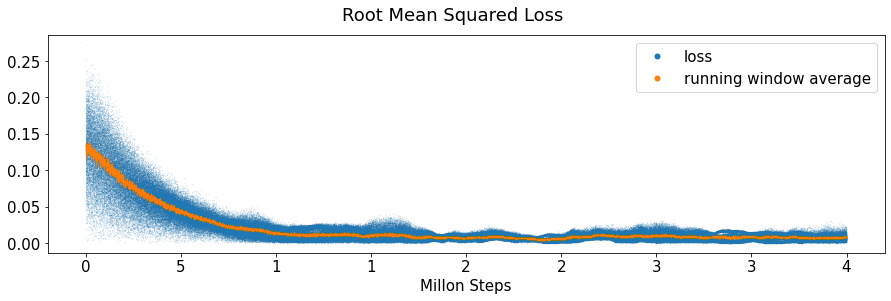

In [70]:
from scipy.ndimage import uniform_filter1d

print(np.mean(metric_dict['loss'][backwards_index:]))
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(metric_dict['loss'],'.',markersize=0.1, label='loss')
average_loss = uniform_filter1d(metric_dict['loss'],size=100)
ax.plot(average_loss,'.', markersize=0.1, label='running window average')
lgnd = ax.legend(loc='upper right',markerscale=100)
xticks = ax.get_xticks().tolist()
xlabels = [str(xlabel)[0] for xlabel in xticks]
ax.set_xticks(xticks[1:-1])
ax.set_xticklabels(xlabels[1:-1])
ax.set_xlabel('Millon Steps')
fig.suptitle('Root Mean Squared Loss')
plt.savefig(dir_path + 'loss_dotsplot.png')

In [71]:
metric_df = pd.DataFrame(metric_dict)
with open(dir_path + r'metric', 'wb') as f:
    feather.write_feather(metric_df, f)

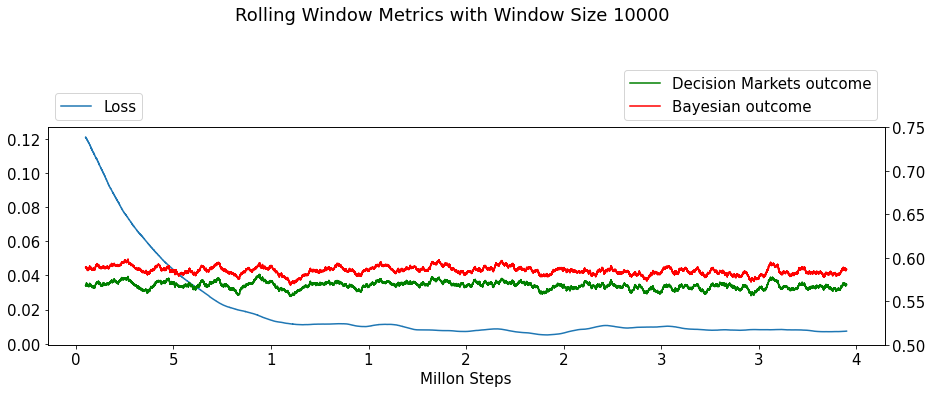

In [72]:
rolling_window_size = 10000
rolling_df = metric_df.loc[:, ['loss', 'dm_outcome', 'bayesian_outcome', 'dr_outcome']].rolling(rolling_window_size, center=True).mean()

fig,ax1 = plt.subplots(figsize=(15,4))
ax2 = ax1.twinx()
ax1.plot(rolling_df['loss'], label='Loss')
ax2.plot(rolling_df['dm_outcome'],'g', label='Decision Markets outcome')
ax2.plot(rolling_df['bayesian_outcome'], 'r', label='Bayesian outcome')
# ax2.plot(rolling_df['dr_outcome'], 'b.',markersize=0.01)
ax2.set_ylim([0.5,0.75])
ax1.legend(loc='lower left', bbox_to_anchor=(0,1))
ax2.legend(loc='lower right', bbox_to_anchor=(1,1))
xticks = ax1.get_xticks().tolist()
xlabels = [str(xlabel)[0] for xlabel in xticks]
ax1.set_xticks(xticks[1:-1])
ax1.set_xticklabels(xlabels[1:-1])
ax1.set_xlabel('Millon Steps')
fig.suptitle('Rolling Window Metrics with Window Size ' + str(rolling_window_size), y=1.3)
plt.savefig(dir_path + 'loss_reward_plot.png')

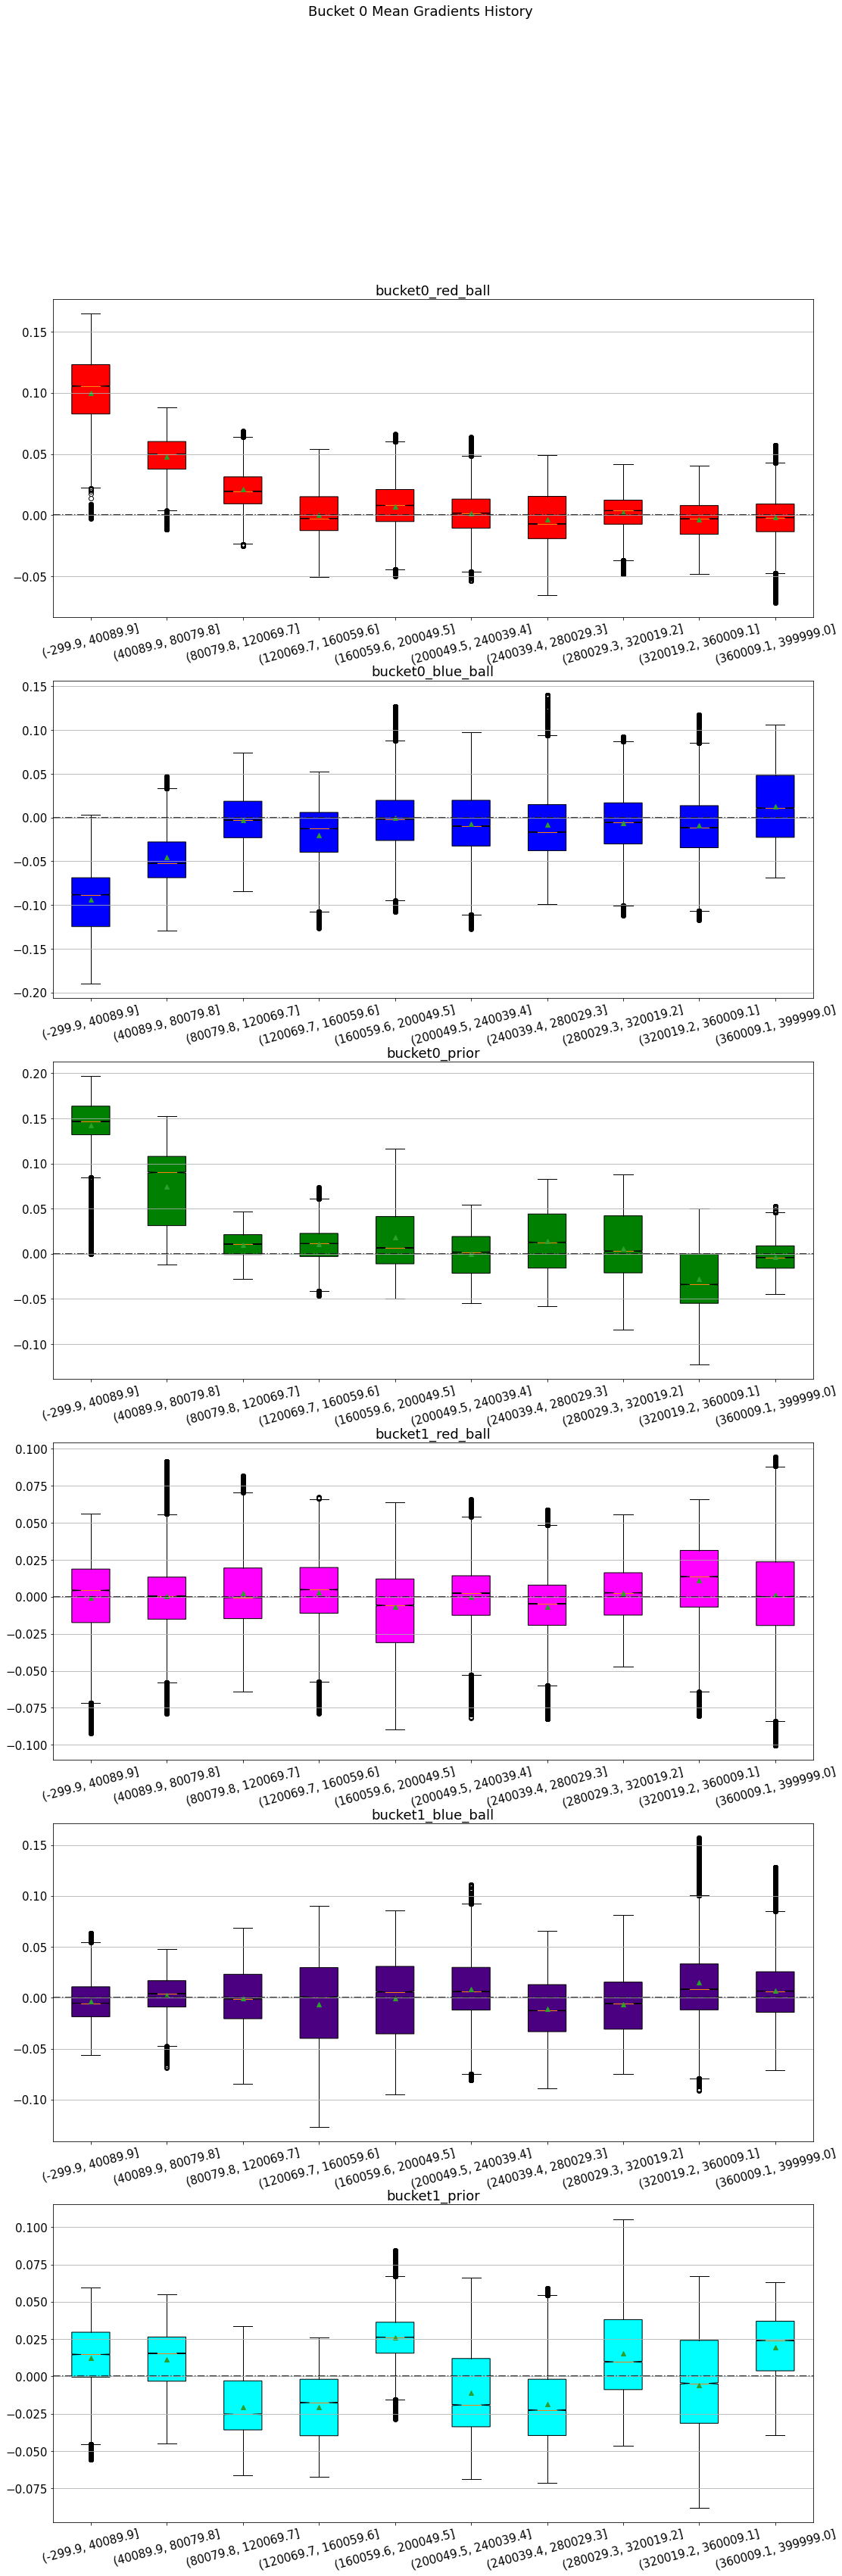

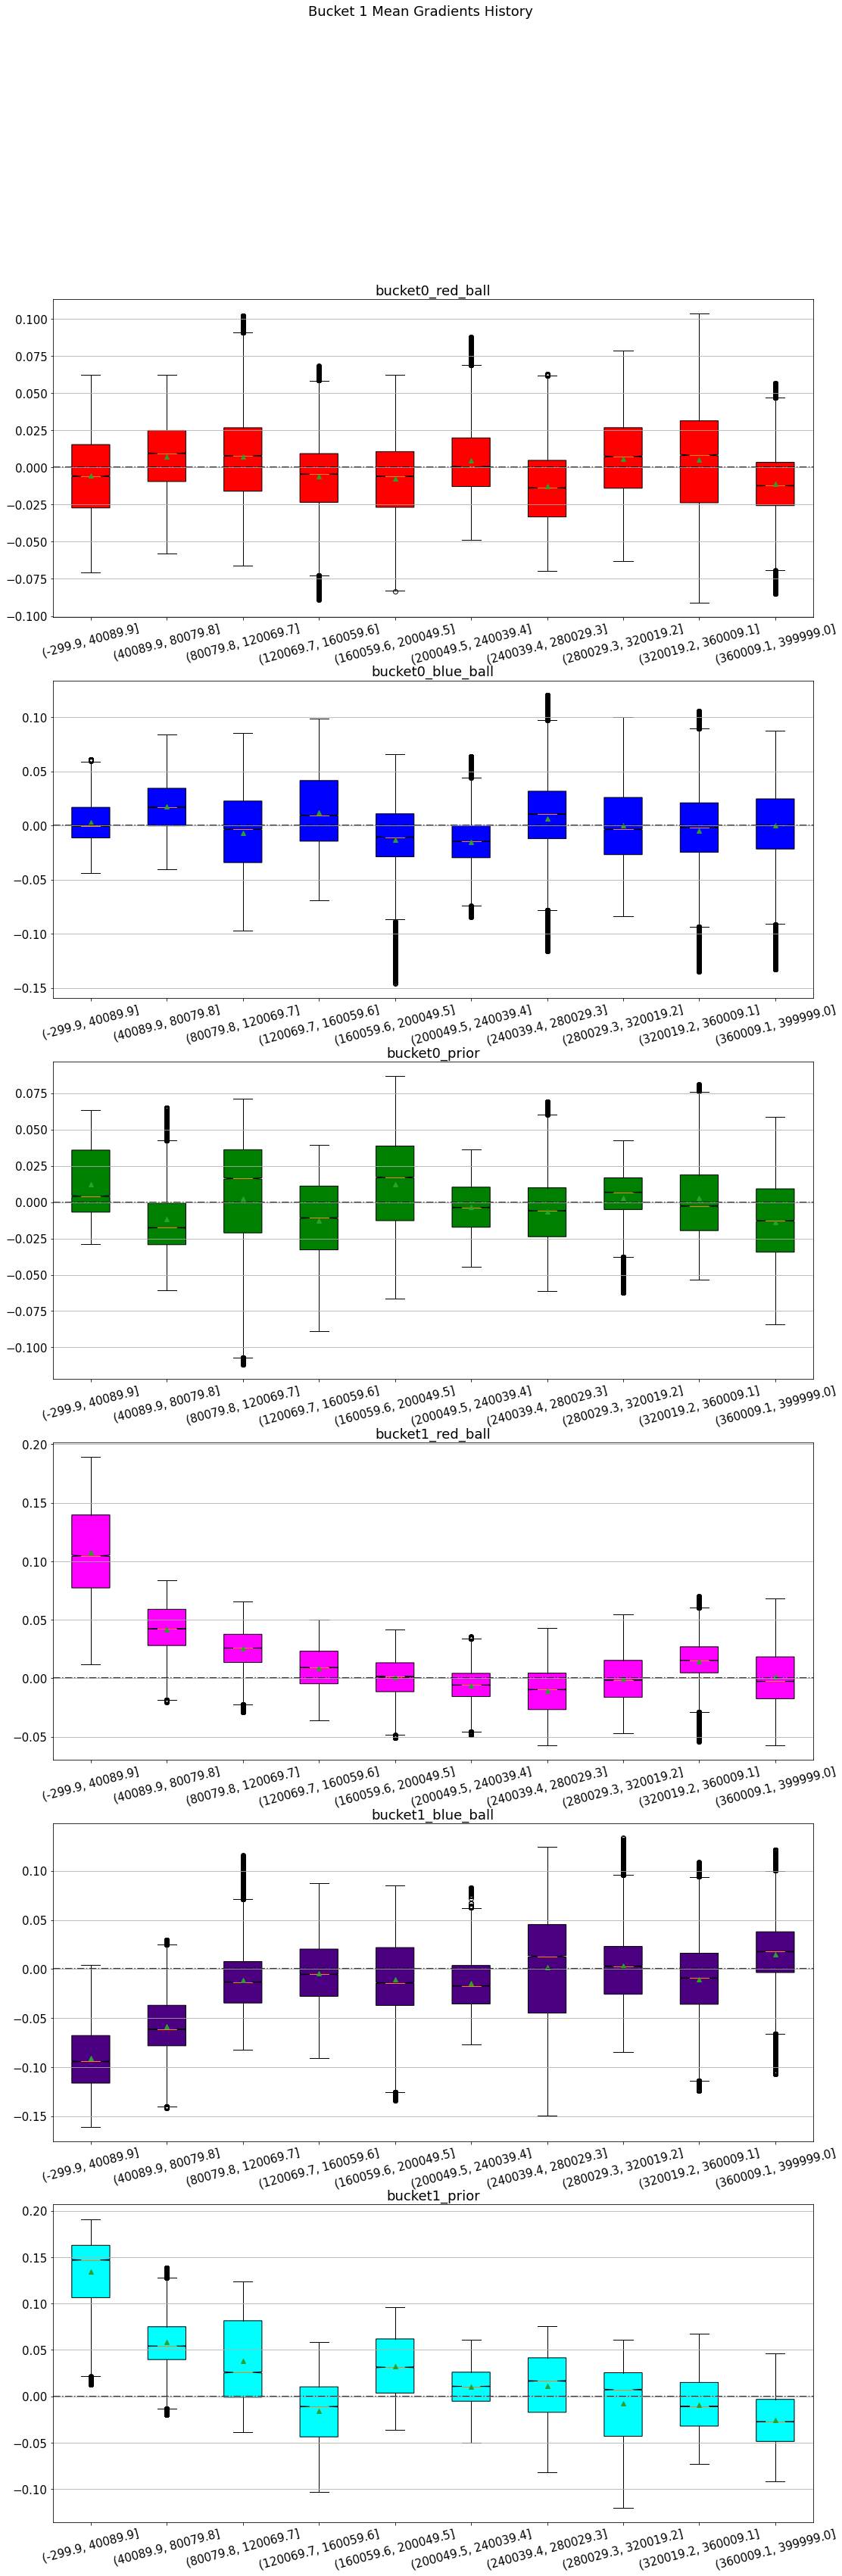

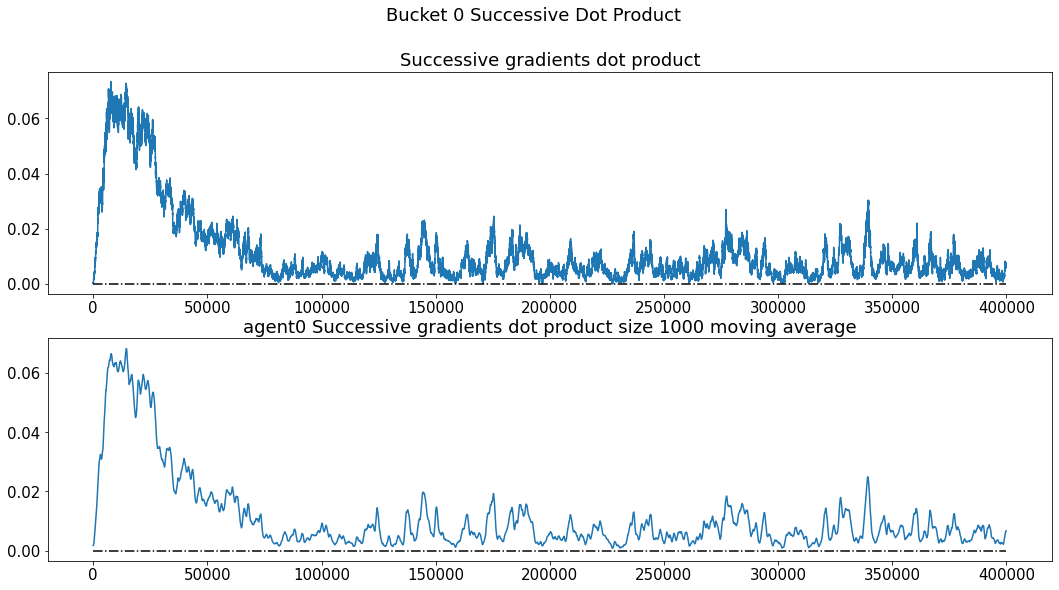

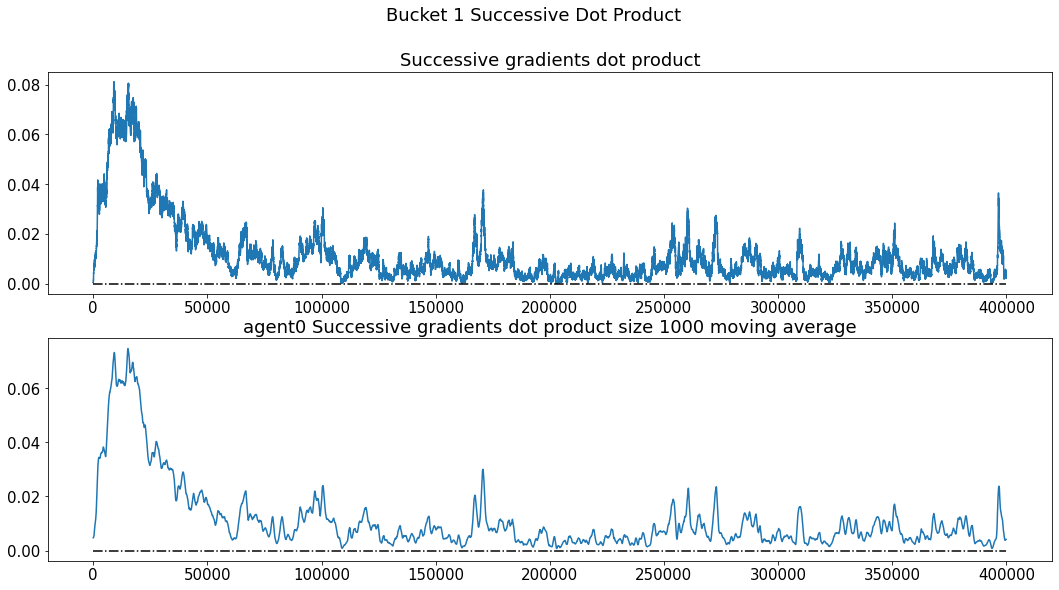

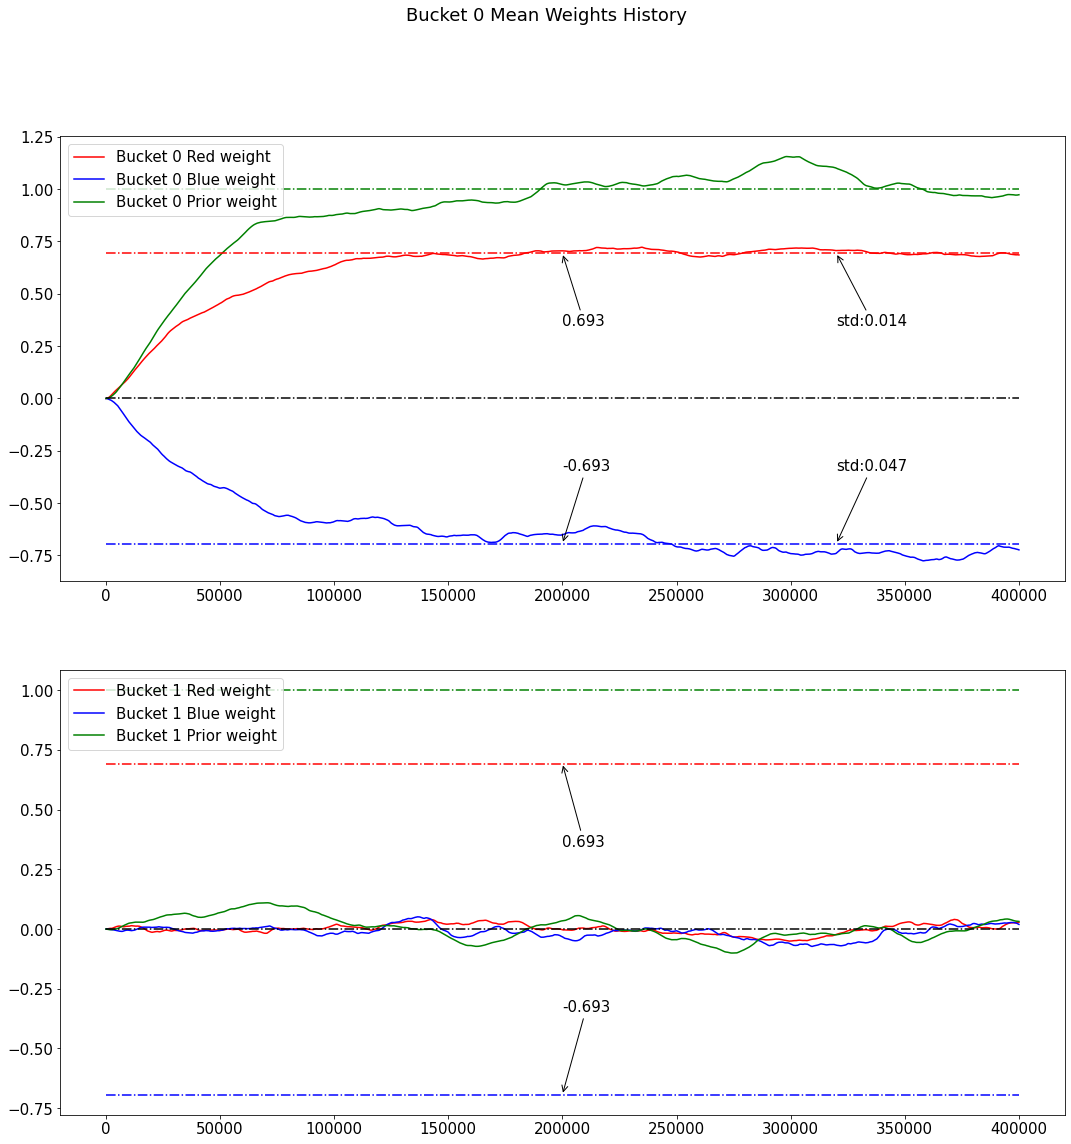

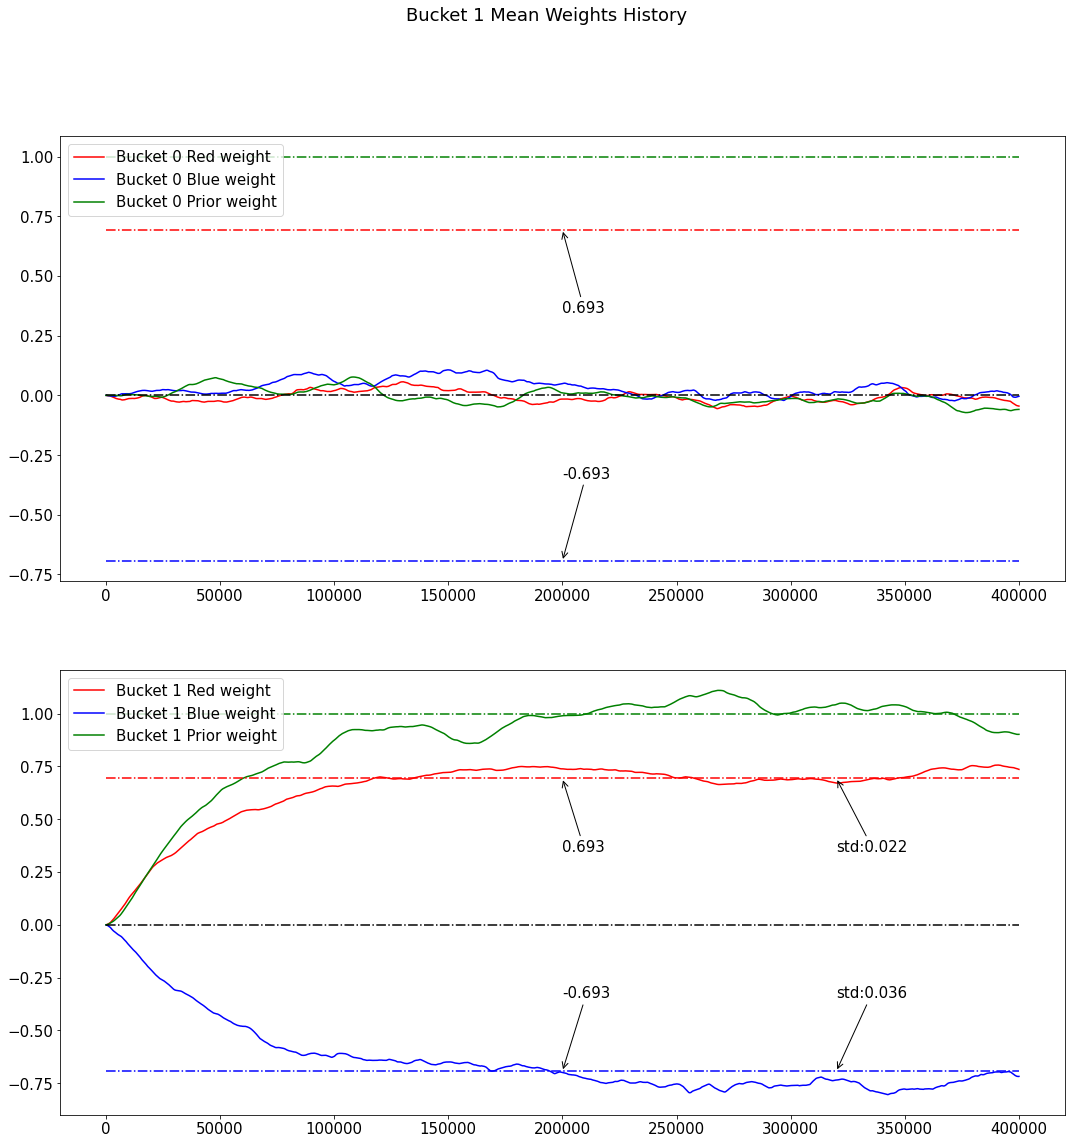

In [73]:
for agent in agent_list:
#     agent.reward_history_plot()
    agent.mean_gradients_history_plot()
    agent.mean_gradients_successive_dot_product_plot()
#     agent.mean_history_plot()
    agent.mean_weights_history_plot()

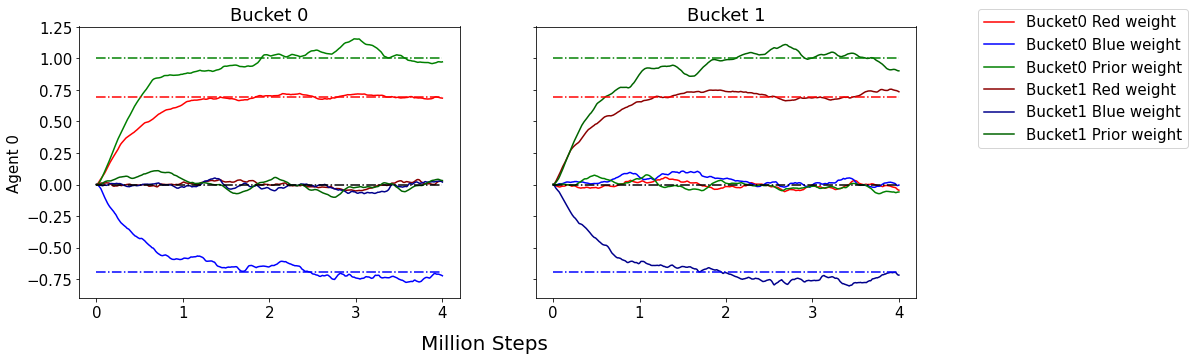

In [74]:
feature_num = 3

fig, axs=plt.subplots(agent_num, action_num, figsize=(15, 5 * agent_num), sharex=True, sharey=True, squeeze=False)


for agent, ag_no in zip(agent_list, range(agent_num)):
    mean_weights_df_list = agent.mean_weights_history_df() 
    reward_df = agent.reward_history_dataframe()
    with open(dir_path + f'{agent.name}_score', 'wb') as f:
        feather.write_feather(reward_df, f)
    # Save the weights
    for no in range(2):
        with open(dir_path + f'{agent.name}_bucket{no}_weights', 'wb') as f:
            feather.write_feather(mean_weights_df_list[no], f)
    
    for df, ac_no in zip(mean_weights_df_list, range(2)):

        axs[ag_no, ac_no].plot(df.iloc[1:, 0 * feature_num + 0],
                               label='Bucket0 Red weight', color='red')
        axs[ag_no, ac_no].plot(df.iloc[1:, 0 * feature_num + 1],
                               label='Bucket0 Blue weight', color='blue')
        axs[ag_no, ac_no].plot(df.iloc[1:, 0 * feature_num + 2],
                               label='Bucket0 Prior weight', color='green')

        axs[ag_no, ac_no].plot(df.iloc[1:, 1 * feature_num + 0],
                               label='Bucket1 Red weight', color='darkred')
        axs[ag_no, ac_no].plot(df.iloc[1:, 1 * feature_num + 1],
                               label='Bucket1 Blue weight', color='darkblue')
        axs[ag_no, ac_no].plot(df.iloc[1:, 1 * feature_num + 2],
                               label='Bucket1 Prior weight', color='darkgreen')
                
for r_no in range(agent_num):
    axs[r_no, 0].set_ylabel(f'Agent {r_no}')
    for c_no in range(action_num):
        if r_no == 0:
            axs[r_no, c_no].set_title(f'Bucket {c_no}')
        axs[r_no, c_no].hlines(y=np.log(pr_red_ball_red_bucket / pr_red_ball_blue_bucket), xmin=0,

                            xmax=len(df), colors='red',
                                     linestyles='dashdot')
        axs[r_no, c_no].hlines(
                y=np.log((1 - pr_red_ball_red_bucket) / (1 - pr_red_ball_blue_bucket)), xmin=0,
                xmax=len(df), colors='blue',
                linestyles='dashdot')
        axs[r_no, c_no].hlines(y=1, xmin=0, xmax=len(df), colors='green', linestyles='dashdot')
        axs[r_no, c_no].hlines(y=0, xmin=0, xmax=len(df), colors='black', linestyles='dashdot')

xticks = axs[-1, 0].get_xticks().tolist()
xlabels = [str(xlabel)[0] for xlabel in xticks]
axs[-1,0].set_xticks(xticks[1:-1])
axs[-1,0].set_xticklabels(xlabels[1:-1])


handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.95, 0.95), ncol=1)
fig.text(0.5, 0.0, 'Million Steps', ha='center', va='center', fontsize=20)
# fig.text(0.75, 1, 'Bucket 1', ha='center', va='center', fontsize=20)


plt.savefig(dir_path + 'mean_weights.png', bbox_inches='tight')



Text(0.5, 1.0, 'Signal from Bucket 1')

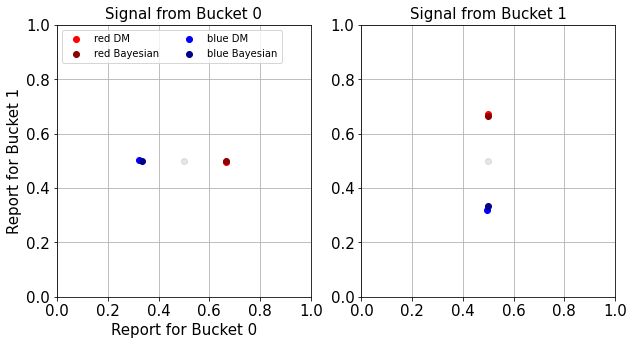

In [101]:
def context_weights_report(context_array, weights_mat):
    return np.matmul(context_array.reshape(1, 6), weights_mat)


init_logit_prior = (0, 0)

nrow = agent_num
ncol = action_num
fig, axs = plt.subplots(nrow, ncol, figsize=(5*ncol, 5*nrow), squeeze=False)

for ball_col in ['red', 'blue']:
    for bucket_i in range(action_num):
        for ag_i in range(agent_num):
            
            # Generate a numpy mat average weight for each agent
            mean_weights_df_list = agent_list[ag_i].mean_weights_history_df() 
            bu0_weights = mean_weights_df_list[0].tail(training_episodes // evaluation_step // 4).mean().values.reshape((6, 1))
            bu1_weights = mean_weights_df_list[1].tail(training_episodes // evaluation_step // 4).mean().values.reshape((6, 1))
            weight_mat = np.concatenate((bu0_weights, bu1_weights), axis=1)
            
            reports = np.empty((0, 2), float)

            if ag_i == 0:
                prev_reports = np.zeros(2)
                prev_ba_reports = np.zeros(2)

            signal_array = signal_encode(ball_col, bucket_i, prev_reports)
            reports = context_weights_report(signal_array, weight_mat)
            ba_signal_array = signal_encode(ball_col, bucket_i, prev_ba_reports)
            ba_reports = BayesianUpdateMat(signal_array, pr_red_ball_red_bucket, pr_red_ball_blue_bucket)
            
            axs[ag_i, bucket_i].scatter(expit(reports[0, 0]), expit(reports[0, 1]), marker='o', color=ball_col, label=f'{ball_col} DM')
            axs[ag_i, bucket_i].scatter(expit(ba_reports[0]), expit(ba_reports[1]), marker='o', color=f'dark{ball_col}', label=f'{ball_col} Bayesian')
            axs[ag_i, bucket_i].set_ylim(0.0, 1)
            axs[ag_i, bucket_i].set_xlim(0.0, 1)
            axs[ag_i, bucket_i].grid(True)
            if ag_i == 0:
                axs[ag_i, bucket_i].scatter(0.5, 0.5, marker='o', color='grey', alpha=0.1)
            else:
                axs[ag_i, bucket_i].scatter(expit(prev_reports[0, 0]), expit(prev_reports[0, 1]), marker='o', color=ball_col, alpha=0.1)
            
            axs[-1, 0].set_xlabel('Report for Bucket 0', fontsize=15)
            axs[-1, 0].set_ylabel('Report for Bucket 1', fontsize=15)
            
            prev_reports = reports.copy()
            prev_ba_reports = ba_reports.copy()
            
axs[0, 0].legend(loc='upper left', ncol=2, fontsize=10)
axs[0, 0].set_title('Signal from Bucket 0', fontsize=15)
axs[0, 1].set_title('Signal from Bucket 1', fontsize=15)

plt.savefig(dir_path + 'reports.png', bbox_inches='tight')

In [103]:
my_v_df = pd.DataFrame(agent_list[0].v_weights_history_list, columns=['bucket0 red', 'bucket0 blue', 'bucket0 prior', 'bucket1 red', 'bucket1 blue', 'bucket1 prior'])

In [104]:
my_q0_df = pd.DataFrame(agent_list[0].q_weights_history_list[0], columns=['bucket0 red', 'bucket0 blue', 'bucket0 prior', 'bucket1 red', 'bucket1 blue', 'bucket1 prior'])

In [115]:
my_q1_df = pd.DataFrame(agent_list[0].q_weights_history_list[1], columns=['bucket0 red', 'bucket0 blue', 'bucket0 prior', 'bucket1 red', 'bucket1 blue', 'bucket1 prior'])

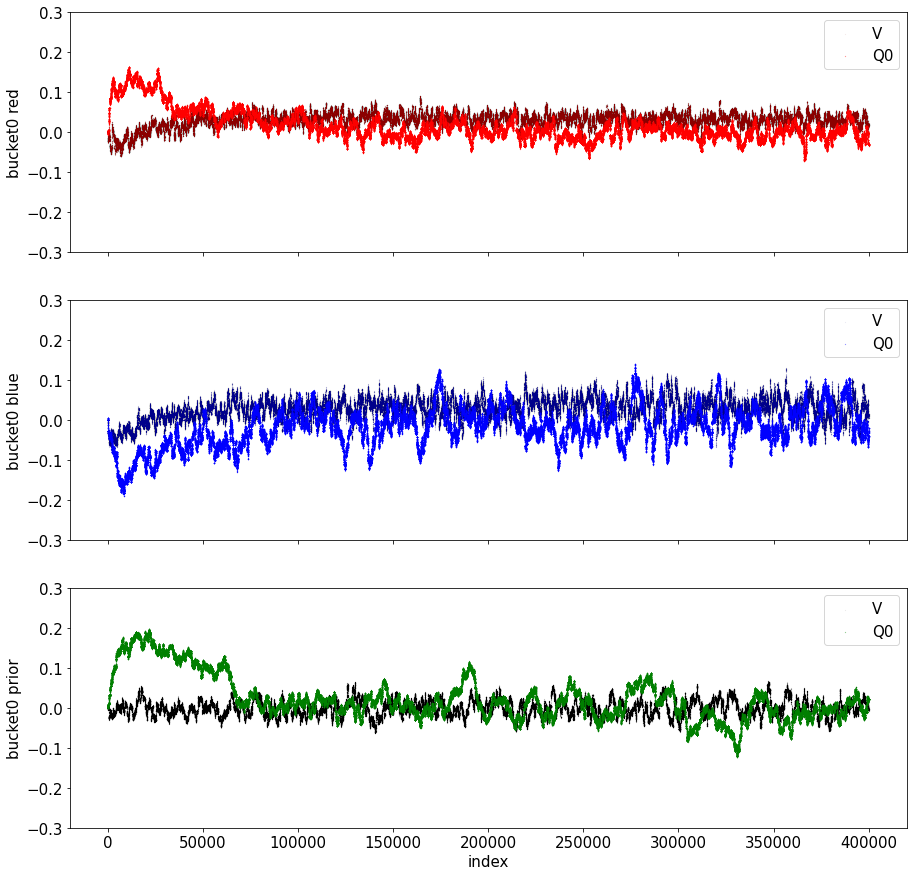

In [119]:
fig, axs = plt.subplots(3, figsize=(15, 5 * 3), sharex=True)
for i, col in zip(range(3), ['red', 'blue', 'prior']):
    my_v_df.reset_index().plot.scatter(x='index', y=f'bucket0 {col}', marker='.',
                                   color=f'dark{col}' if col != 'prior' else 'black', 
                                    ylim=(-0.15, 0.15), ax=axs[i], s=0.1, alpha=0.2, label='V')    
    my_q0_df.reset_index().plot.scatter(x='index', y=f'bucket0 {col}', marker='.',
                                       color=col if col != 'prior' else 'green', 
                                        ylim=(-0.3, 0.3), ax=axs[i], s=0.1, label='Q0')
#     my_q1_df.reset_index().plot.scatter(x='index', y=f'bucket0 {col}', marker='.',
#                                    color=col if col != 'prior' else 'green', 
#                                     ylim=(-0.3, 0.3), ax=axs[i], s=0.1, label='Q1')
# plt.legend(loc='upper right', makerscale=2.0)

plt.savefig(dir_path + 'vq.png', bbox_inches='tight')